## Import Libraries 

In [1]:
import warnings
import sys
sys.path.insert(0, '../../src')
warnings.filterwarnings('ignore')

In [2]:
import ABC_train_test2
import californiaDataset
import network
import dataset
import sanityChecks
import performanceMetrics
import torch 
from torch.utils.data import random_split 
import scrapbook as sb
from statistics import mean 
import catboost as ctb 
from sklearn.model_selection import train_test_split

## Parameters 

In [3]:
variance = 1

## Dataset - Boston Housing 

In [4]:
#Parameters 
n_features = 8
n_samples= 20640
n_target = 1 

In [5]:
X,Y = californiaDataset.california_data()

        X1    X2    X3   X4     X5     X6    X7      X8   X9    X10   X11  \
0  0.00632  18.0  2.31  0.0  0.538  6.575  65.2  4.0900  1.0  296.0  15.3   
1  0.02731   0.0  7.07  0.0  0.469  6.421  78.9  4.9671  2.0  242.0  17.8   
2  0.02729   0.0  7.07  0.0  0.469  7.185  61.1  4.9671  2.0  242.0  17.8   
3  0.03237   0.0  2.18  0.0  0.458  6.998  45.8  6.0622  3.0  222.0  18.7   
4  0.06905   0.0  2.18  0.0  0.458  7.147  54.2  6.0622  3.0  222.0  18.7   

      X12   X13     Y  
0  396.90  4.98  24.0  
1  396.90  9.14  21.6  
2  392.83  4.03  34.7  
3  394.63  2.94  33.4  
4  396.90  5.33  36.2  


In [6]:
#Train test split for dataset 
real_dataset = dataset.CustomDataset(X,Y)
train_size = round(0.8 * n_samples)
test_size = n_samples - train_size
train_data, test_data = random_split(real_dataset,[train_size,test_size])

## Training Parameters 



In [7]:
batch_size = 5000
n_epochs = 1000
#Select the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### MSE Threshold and Mean Coeff Values 

1. Fetch MSE threshold for training the ABC-GAN 
2. The ABC-GAN will be trained until the threshold MSE is achieved or until it completes 5000 epochs 
3. The threshold mse is the mean mse of Catboost over 10 runs

In [8]:
books = sb.read_notebooks('./BaseLine_Model_Output')
catboostMSE = []
for nb in books.notebooks: 
    catboostMSE.append(nb.scraps['Catboost MSE'].data)
    
#Threshold MSE     
threshold_mse = mean(catboostMSE)

print(threshold_mse)

0.10094117185431159


# ABC Pre-generator Model 

1. The catboost model is used as a pre-generator model for the ABC-GAN. 
2. The model is first trained on the entire dataset 
3. It generats X,Y pairs and we add some Gaussian noise with mean 0 and variance 1 to it which is then feed as input to the generator.


In [9]:
#Train the Model 
prior_model = ctb.CatBoostRegressor()
prior_model.fit(X,Y)

Learning rate set to 0.034573
0:	learn: 0.9806058	total: 66.9ms	remaining: 1m 6s
1:	learn: 0.9606716	total: 69.6ms	remaining: 34.7s
2:	learn: 0.9390920	total: 72.2ms	remaining: 24s
3:	learn: 0.9209237	total: 74.8ms	remaining: 18.6s
4:	learn: 0.9046978	total: 77.1ms	remaining: 15.3s
5:	learn: 0.8896854	total: 79.1ms	remaining: 13.1s
6:	learn: 0.8724151	total: 81.2ms	remaining: 11.5s
7:	learn: 0.8558633	total: 83.2ms	remaining: 10.3s
8:	learn: 0.8400199	total: 84.9ms	remaining: 9.35s
9:	learn: 0.8229065	total: 86.5ms	remaining: 8.56s
10:	learn: 0.8057776	total: 88ms	remaining: 7.91s
11:	learn: 0.7907426	total: 89.5ms	remaining: 7.37s
12:	learn: 0.7753485	total: 91ms	remaining: 6.91s
13:	learn: 0.7601130	total: 92.4ms	remaining: 6.5s
14:	learn: 0.7475256	total: 93.9ms	remaining: 6.17s
15:	learn: 0.7326054	total: 95.4ms	remaining: 5.87s
16:	learn: 0.7206853	total: 96.8ms	remaining: 5.6s
17:	learn: 0.7077303	total: 98.2ms	remaining: 5.36s
18:	learn: 0.6955287	total: 99.4ms	remaining: 5.13s


335:	learn: 0.1657088	total: 377ms	remaining: 745ms
336:	learn: 0.1653987	total: 378ms	remaining: 743ms
337:	learn: 0.1652355	total: 378ms	remaining: 741ms
338:	learn: 0.1648615	total: 379ms	remaining: 740ms
339:	learn: 0.1646361	total: 380ms	remaining: 738ms
340:	learn: 0.1643424	total: 381ms	remaining: 736ms
341:	learn: 0.1641025	total: 382ms	remaining: 734ms
342:	learn: 0.1637969	total: 383ms	remaining: 733ms
343:	learn: 0.1634989	total: 383ms	remaining: 731ms
344:	learn: 0.1631288	total: 384ms	remaining: 730ms
345:	learn: 0.1630031	total: 385ms	remaining: 728ms
346:	learn: 0.1625470	total: 386ms	remaining: 727ms
347:	learn: 0.1622545	total: 387ms	remaining: 725ms
348:	learn: 0.1619905	total: 388ms	remaining: 724ms
349:	learn: 0.1619095	total: 389ms	remaining: 723ms
350:	learn: 0.1616910	total: 390ms	remaining: 721ms
351:	learn: 0.1613933	total: 391ms	remaining: 720ms
352:	learn: 0.1611181	total: 392ms	remaining: 719ms
353:	learn: 0.1607851	total: 393ms	remaining: 718ms
354:	learn: 

559:	learn: 0.1179853	total: 566ms	remaining: 445ms
560:	learn: 0.1177859	total: 567ms	remaining: 444ms
561:	learn: 0.1175936	total: 568ms	remaining: 443ms
562:	learn: 0.1174509	total: 569ms	remaining: 442ms
563:	learn: 0.1172948	total: 570ms	remaining: 440ms
564:	learn: 0.1171456	total: 571ms	remaining: 439ms
565:	learn: 0.1170940	total: 571ms	remaining: 438ms
566:	learn: 0.1169048	total: 572ms	remaining: 437ms
567:	learn: 0.1167425	total: 573ms	remaining: 436ms
568:	learn: 0.1166102	total: 574ms	remaining: 435ms
569:	learn: 0.1164306	total: 575ms	remaining: 434ms
570:	learn: 0.1162908	total: 576ms	remaining: 433ms
571:	learn: 0.1161027	total: 577ms	remaining: 432ms
572:	learn: 0.1159918	total: 578ms	remaining: 431ms
573:	learn: 0.1157478	total: 579ms	remaining: 430ms
574:	learn: 0.1155859	total: 580ms	remaining: 429ms
575:	learn: 0.1154385	total: 581ms	remaining: 428ms
576:	learn: 0.1153858	total: 582ms	remaining: 427ms
577:	learn: 0.1153157	total: 583ms	remaining: 426ms
578:	learn: 

778:	learn: 0.0879793	total: 757ms	remaining: 215ms
779:	learn: 0.0879265	total: 758ms	remaining: 214ms
780:	learn: 0.0877857	total: 759ms	remaining: 213ms
781:	learn: 0.0877384	total: 760ms	remaining: 212ms
782:	learn: 0.0876342	total: 760ms	remaining: 211ms
783:	learn: 0.0874749	total: 761ms	remaining: 210ms
784:	learn: 0.0872790	total: 762ms	remaining: 209ms
785:	learn: 0.0871866	total: 763ms	remaining: 208ms
786:	learn: 0.0870605	total: 764ms	remaining: 207ms
787:	learn: 0.0869480	total: 765ms	remaining: 206ms
788:	learn: 0.0868796	total: 766ms	remaining: 205ms
789:	learn: 0.0867424	total: 767ms	remaining: 204ms
790:	learn: 0.0866955	total: 768ms	remaining: 203ms
791:	learn: 0.0865584	total: 769ms	remaining: 202ms
792:	learn: 0.0864905	total: 770ms	remaining: 201ms
793:	learn: 0.0863819	total: 771ms	remaining: 200ms
794:	learn: 0.0863573	total: 772ms	remaining: 199ms
795:	learn: 0.0862351	total: 773ms	remaining: 198ms
796:	learn: 0.0861251	total: 774ms	remaining: 197ms
797:	learn: 

# ABC GAN Model

### Training the network
**Training ABC-GAN for n_epochs number of epochs** 

In [20]:
gen = network.Generator(n_features+1).to(device)
disc = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.1, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.1, betas=(0.5, 0.999))

In [21]:
#Training the ABC_GAN 
discLossA1,genLossA1 = ABC_train_test2.training_GAN(disc,gen,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,prior_model,variance,device)
sb.glue("ABC_GAN_1 Generator Loss",genLossA1)
sb.glue("ABC_GAN_1 Discriminator Loss",discLossA1)

In [22]:
ABC_GAN1_metrics=ABC_train_test2.test_generator(gen,test_data,prior_model,variance,"1",device)
sb.glue("ABC_GAN_1 Metrics",ABC_GAN1_metrics)

print("MSE")
print(mean(ABC_GAN1_metrics[0]))

MSE
0.23538626313544792


#### Sanity Checks 

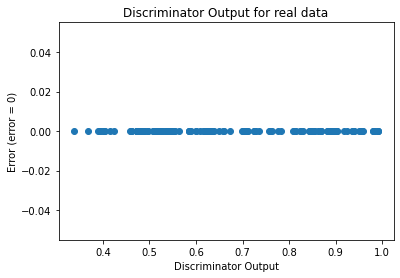

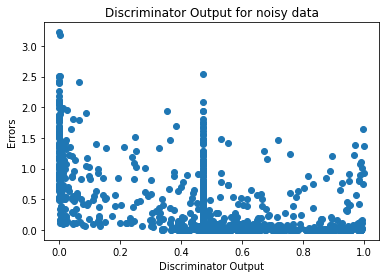

In [17]:
sanityChecks.discProbVsError(real_dataset,disc,device)

# ABC - GAN Model with skip connection

In [14]:
#Generator
gen3 = network.GeneratorWithSkipConnection(n_features+1).to(device)
constraints=network.weightConstraint()
#Discriminator 
disc3 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen3.parameters(), lr=0.1, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc3.parameters(), lr=0.1, betas=(0.5, 0.999))


In [15]:
discLossA3,genLossA3 = ABC_train_test2.training_GAN_skip_connection(disc3,gen3,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,prior_model,variance,device)
sb.glue("ABC_GAN_3 Generator Loss",genLossA3)
sb.glue("ABC_GAN_3 Discriminator Loss",discLossA3)

In [17]:
ABC_GAN3_metrics=ABC_train_test2.test_generator(gen3,test_data,prior_model,variance,"3",device)
sb.glue("ABC_GAN_3 Metrics",ABC_GAN3_metrics)

print("MSE")
print(mean(ABC_GAN3_metrics[0]))

MSE
0.2197485334194797


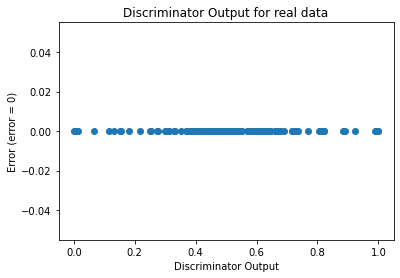

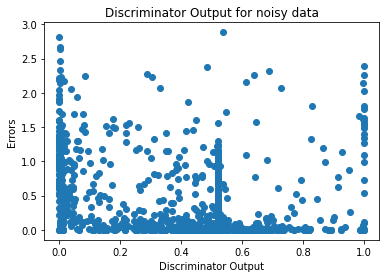

In [18]:
sanityChecks.discProbVsError(real_dataset,disc3,device)

## Skip Connection Model Analysis - ABC-GAN 

### Weight Analysis 

Study the weights of the skip connection layer

Equation of the skip connection is 

$output = y_{gan} * w + y_{abc} * (1-w)$

In [19]:
print("Weight of the node at skip connection")
for name,param in gen3.named_parameters():
    if(name == "skipNode.weight"):
        print(param)
        sb.glue("Skip Connection Weight",param.item())

Weight of the node at skip connection
Parameter containing:
tensor([[0.7222]], requires_grad=True)
